In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import VAR
from pandas.plotting import register_matplotlib_converters

from datetime import datetime 

import joblib

In [13]:
data = pd.read_csv('../data/model_data.csv', index_col=0, parse_dates=True)
data.head()

,DayOfWeek,Open,High,Low,Close,Adj Close,Volume,OC Difference,HL Difference,OC %Change,...,first_diff_volume,first_diff_avg_volume_10_day,first_diff_close_bracket,first_diff_short_ema,first_diff_long_ema,first_diff_close_lag_1,first_diff_close_lag_2,first_diff_close_lag_3,first_diff_close_lag_4,first_diff_close_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-23,4,7420.310059,7465.870117,7405.399902,7413.839844,7413.839844,1888600000,6.470215,60.470215,-0.000872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-24,5,7443.709961,7489.540039,7442.990234,7485.399902,7485.399902,1892990000,-41.689941,46.549805,0.005601,...,4390000.0,NaN,0.0,11.009240,5.300745,NaN,NaN,NaN,NaN,NaN
2018-08-27,1,7527.370117,7560.759766,7512.020020,7559.129883,7559.129883,2333790000,-31.759766,48.739746,0.004219,...,440800000.0,NaN,100.0,20.658585,10.369577,71.560058,NaN,NaN,NaN,NaN
2018-08-28,2,7580.850098,7588.720215,7556.709961,7570.250000,7570.250000,1980270000,10.600098,32.010254,-0.001398,...,-353520000.0,NaN,0.0,19.191128,10.425173,73.729981,71.560058,NaN,NaN,NaN
2018-08-29,3,7585.129883,7661.950195,7583.520020,7660.180176,7660.180176,1909880000,-75.050293,78.430175,0.009894,...,-70390000.0,NaN,100.0,30.074058,16.314432,11.120117,73.729981,71.560058,NaN,NaN


## XGB Model

In [14]:
features = ['Open', 'High', 'Low', 'Volume', 'OC Difference',
       'HL Difference', 'OC %Change', 'HL %Change', 'Close_Status',
       'Close_Difference', 'Same Bracket', 'Avg_OC_Spread_10_Day',
       'Avg_Volume_10_Day', 'Volatility_10_Day', 'Price_Change_Magnitude',
       'Price_Direction', 'MA_Volume_Ratio', 'Close_Bracket', 'Close_Lag_5',
       'Close_Lag_4', 'Close_Lag_3', 'Close_Lag_2', 'Close_Lag_1', 'ShortEMA',
       'LongEMA', 'MACD',]

In [15]:
features_2 = ['Avg_OC_Spread_10_Day',
       'Avg_Volume_10_Day', 'Volatility_10_Day', 'Price_Change_Magnitude',
       'Price_Direction', 'MA_Volume_Ratio', 'Close_Lag_5',
       'Close_Lag_4', 'Close_Lag_3', 'Close_Lag_2', 'Close_Lag_1', 'ShortEMA',
       'LongEMA', 'MACD',]

In [16]:
X = data[features_2]
y = data['Close']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state = 42)

### Model Building

In [17]:

# Preprocessing for numerical data
ss = StandardScaler()

# Create a preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', ss),
                        ('model', XGBRegressor())])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3,5],
    'model__min_child_weight': [1,3],
    'model__subsample': [ 0.7, 1.0],
    'model__colsample_bytree': [ 0.7, 1.0]
}

# Set up the grid search
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
#print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor', StandardScaler()),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=None,
                                        

Best parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 3, 'model__n_estimators': 300, 'model__subsample': 1.0}

### Model Performance

In [18]:
# Use the best model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


Mean Squared Error: 6516.379301165438
R^2 Score: 0.9992438700733794


In [19]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_child_weight': 3, 'model__n_estimators': 300, 'model__subsample': 1.0}


### Model Predictions Plotted

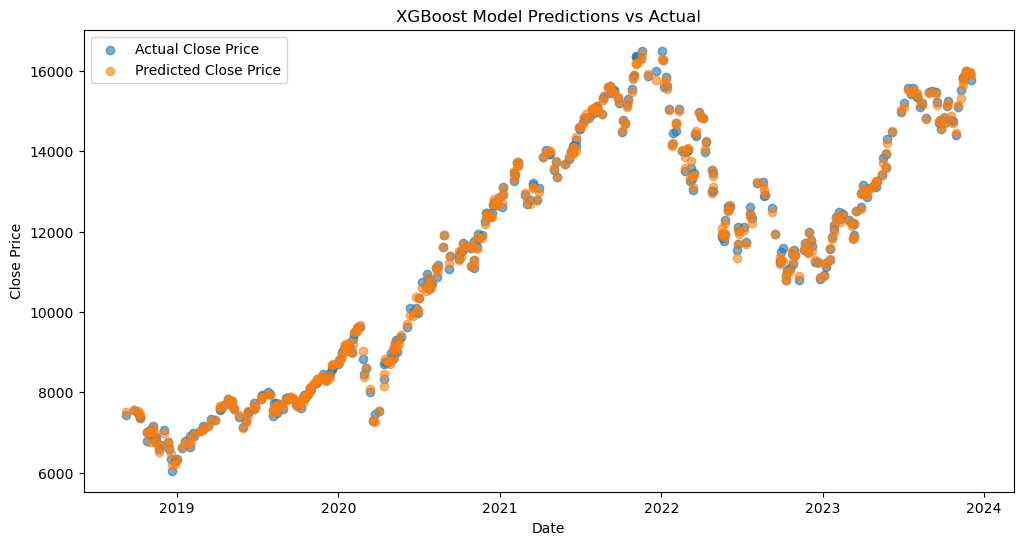

In [20]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test.index, y_test, label='Actual Close Price', alpha=0.6)
plt.scatter(y_test.index, y_pred, label='Predicted Close Price', alpha=0.6)
plt.title('XGBoost Model Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


### Model Assessment

##### Lets do some analysis on the model

In [21]:
min_price = y.min()
max_price = y.max()
range_price = max_price - min_price
std_dev = y.std()

print(f"Minimum 'Close' Price: {min_price}")
print(f"Maximum 'Close' Price: {max_price}")
print(f"Range of 'Close' Prices: {range_price}")
print(f"Standard Deviation of 'Close' Prices: {std_dev}")
print(f"Mean Squared Error: {mse}")


Minimum 'Close' Price: 5899.350098
Maximum 'Close' Price: 16573.339844
Range of 'Close' Prices: 10673.989746
Standard Deviation of 'Close' Prices: 3001.343631015838
Mean Squared Error: 6516.379301165438


### Feature Importance

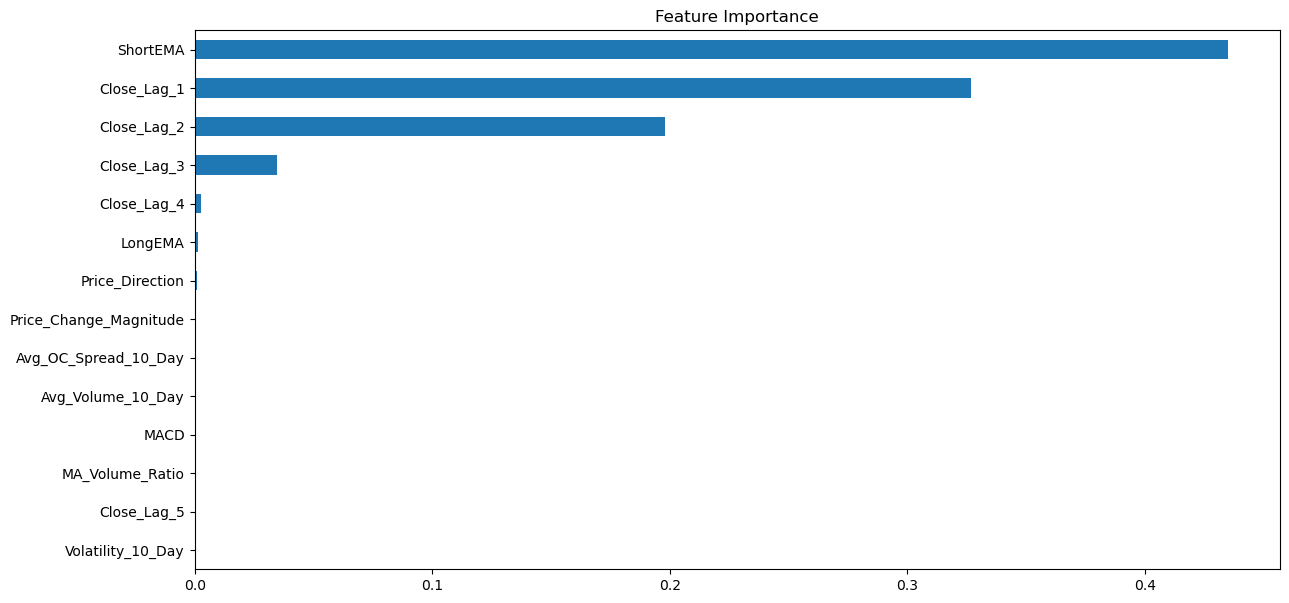

In [22]:
# Ensure you have a model fitted with the best parameters from GridSearchCV or a single run
feature_importances = best_model.named_steps['model'].feature_importances_

# Create a pandas Series for easy plotting
import pandas as pd
importances = pd.Series(feature_importances, index=X.columns)

# Sort importances
sorted_importances = importances.sort_values()

# Plot
plt.figure(figsize=(14, 7))
sorted_importances.plot(kind='barh')
plt.title('Feature Importance')
plt.show()


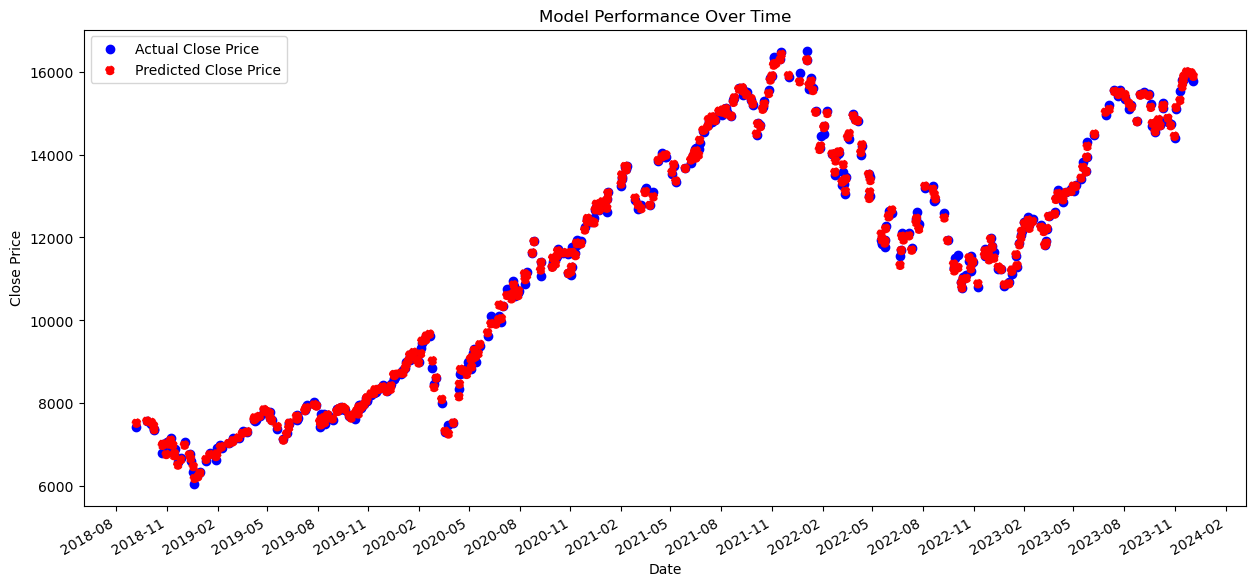

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Actual vs. Predicted Close Price Over Time
plt.figure(figsize=(15, 7))
plt.scatter(y_test.index, y_test, label='Actual Close Price', color='blue', linewidth=1)
plt.scatter(y_test.index, y_pred, label='Predicted Close Price', color='red', linestyle='--', linewidth=1)
plt.title('Model Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the dates as 'Year-Month'
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set major ticks interval to every 3 months
plt.gcf().autofmt_xdate()  # Auto-format the dates to avoid overlap
plt.show()


### Distribution Plot

Mean Absolute Error (MAE): 60.31307012882814


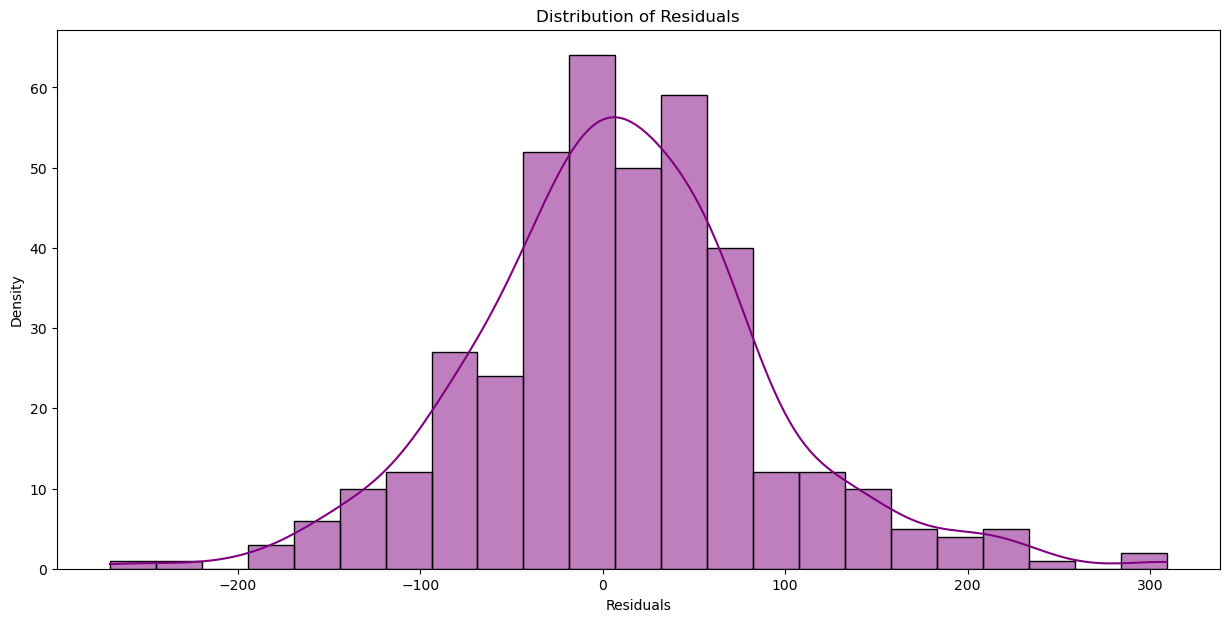

In [24]:
from sklearn.metrics import mean_absolute_error
import seaborn as sns

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Residuals
residuals = y_test - y_pred

# Distribution Plot of Residuals
plt.figure(figsize=(15, 7))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


The MAE of approximately 95.89 is the average absolute error your model makes in predicting the 'Close' price. Compared to the scale of your 'Close' prices, which have a range of over 10,000, a MAE of around 96 suggests that the model predictions are quite close to the actual values on average.

#### Distribution of Residuals:

The distribution of residuals appears to be centered around zero, which is a good sign as it suggests there is no significant bias in your model; that is, it is not systematically overpredicting or underpredicting.
The shape of the distribution seems to have a bell shape, which is also a positive indicator that the errors are normally distributed, a common assumption in many modeling techniques.
There are some long tails, especially on the positive side, indicating the presence of some large errors, although these are less frequent.

In [25]:
import pickle

# Save the model to a file
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

[CV] END model__colsample_bytree=0.7, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=200, model__subsample=0.7; total time=   0.3s
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=300, model__subsample=0.7; total time=   0.5s
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=200, model__subsample=0.7; total time=   0.4s
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=3, model__n_estimators=300, model__subsample=0.7; total time=   0.5s
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=200, model__subsample=0.7; total time=   0.3s
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1

In [74]:
# Calculate the predictions on the training set
training_predictions = best_model.predict(X_train)

# Calculate residuals (differences between actual and predicted values)
residuals = y_train - training_predictions

# Calculate the standard deviation of these residuals
std_dev_residuals = residuals.std()

print("Standard Deviation of Residuals:", std_dev_residuals)

Standard Deviation of Residuals: 10.839669987848684


## Next steps:
- Lets add Open Price as an Input as well
- Lets add Lagged Differences:  "Instead of using the absolute values of previous days' 'Close' prices as features (Close_Lag_1, Close_Lag_2, etc.), you use the differences    between them. For example, instead of using Close_Lag_1 as yesterday's close price, you would use the difference between yesterday's and the day before yesterday's close prices. This helps the model focus on the change or movement from day to day, rather than the absolute price levels."

        data['Diff_Lag_1'] = data['Close'].diff(1)  # Difference from previous day
        data['Diff_Lag_2'] = data['Close'].diff(2)  # Difference from 2 days ago
        # ... and so on

- Volatility Measures: Volatility measures can capture the uncertainty or stability in price movements, which is often a crucial factor in predicting market changes. Here are a few ways to include volatility:
   * Historical Volatility: Calculate the standard deviation of daily price changes over a fixed period (e.g., 10 days).
   * Average True Range (ATR): ATR is a technical analysis indicator that measures market volatility by decomposing the entire range of an asset price for that period.
    
         data['Historical_Volatility'] = data['Close'].pct_change().rolling(window=10).std()
            
- Model Interpretability: Since your model heavily relies on close lag data and EMAs, you might want to experiment with adding or emphasizing other types of features, like the lagged differences or volatility measures, to see if it helps the model pick up on different kinds of information. Ensembling XGBoost with other models can help capture different aspects of the data. Here are a few options:

        Random Forest: A robust and often effective model for a wide range of problems. It can capture different patterns that XGBoost might miss.
        Linear Models (like Ridge or Lasso Regression): These models can provide a different perspective, focusing on linear relationships in the data.
        Neural Networks: A simple feedforward neural network or more complex architectures like LSTMs (if you are dealing with sequence data) can capture non-linear relationships.
        
        
    When ensembling models, you can either use a simple averaging approach or a more complex stacking method where the predictions of individual models become input for a final meta-model.

    Implementing these suggestions involves iterative experimentation. Adjusting your feature set and trying different modeling approaches can provide new insights and potentially improve your model's predictive power, especially in capturing changes in market direction.
 



